In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = "/kaggle/input/cicids2017-full-dataset/combine.csv" 
data = pd.read_csv(file_path)

/tmp/ipykernel_30/2985525147.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [3]:
data.columns = data.columns.str.strip()

In [4]:
columns_to_drop = ['Unnamed: 0', 'Flow ID', 'Source IP', 'Destination IP',
                   'Timestamp', 'Source Port', 'Destination Port', 'Protocol']
data.drop(columns=columns_to_drop, inplace=True, errors='ignore')


In [5]:
print(data['Label'].value_counts())

Label
BENIGN              1672837
DoS Hulk             231073
PortScan             158930
DDoS                 128027
DoS GoldenEye         10293
DoS slowloris          5796
DoS Slowhttptest       5499
Bot                    1966
Infiltration             36
Heartbleed               11
Name: count, dtype: int64


In [6]:
data['Label'] = data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)


In [7]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values
data.fillna(data.median(), inplace=True)

In [8]:
print("Dataset shape after preprocessing:", data.shape)
print(data.head())

Dataset shape after preprocessing: (2214469, 78)
   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0            3.0                2.0                     0.0   
1          109.0                1.0                     1.0   
2           52.0                1.0                     1.0   
3           34.0                1.0                     1.0   
4            3.0                2.0                     0.0   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                         12.0                          0.0   
1                          6.0                          6.0   
2                          6.0                          6.0   
3                          6.0                          6.0   
4                         12.0                          0.0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                    6.0                    6.0                     6.0   
1                    6.0                   

In [9]:
correlation_matrix = data.corr()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
to_drop = [column for column in upper_triangle.columns if any(abs(upper_triangle[column]) > 0.9)]
data.drop(columns=to_drop, inplace=True)

In [10]:
X = data.drop(columns=['Label'])
y = data['Label']

In [12]:
print(data['Label'].value_counts())

Label
0    1672837
1     541632
Name: count, dtype: int64


In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [15]:
X_benign = X_scaled[y == 0]
X_train, X_val = train_test_split(X_benign, test_size=0.25, random_state=42)
X_test = X_scaled[y == 1]  # All attack samples for testing


In [16]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(30, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
encoded = Dense(10, activation='relu', kernel_regularizer=l2(0.001))(encoded)
encoded = Dense(5, activation='relu', kernel_regularizer=l2(0.001))(encoded)
decoded = Dense(15, activation='relu', kernel_regularizer=l2(0.001))(encoded)
decoded = Dense(30, activation='relu', kernel_regularizer=l2(0.001))(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Compile Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=1e-5), loss='mean_squared_error')


In [17]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=1024,
    validation_data=(X_val, X_val),
    verbose=1
)

Epoch 1/100


I0000 00:00:1731854178.990076     112 service.cc:145] XLA service 0x799664003bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731854178.990128     112 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731854178.990133     112 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  95/1226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0075

I0000 00:00:1731854180.978820     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.1259 - val_loss: 1.1887
Epoch 2/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1479 - val_loss: 1.1174
Epoch 3/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0371 - val_loss: 1.0319
Epoch 4/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9392 - val_loss: 0.9749
Epoch 5/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8728 - val_loss: 0.9426
Epoch 6/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9044 - val_loss: 0.9243
Epoch 7/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8662 - val_loss: 0.9096
Epoch 8/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8860 - val_loss: 0.8953
Epoch 9/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8480 - val_loss: 0.8825
Epoch 10/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7955 - val_loss: 0.8722
Epoch 11/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8189 - val_loss: 0.8634
Epoch 12/100
1226/1226 ━━━━━━━━

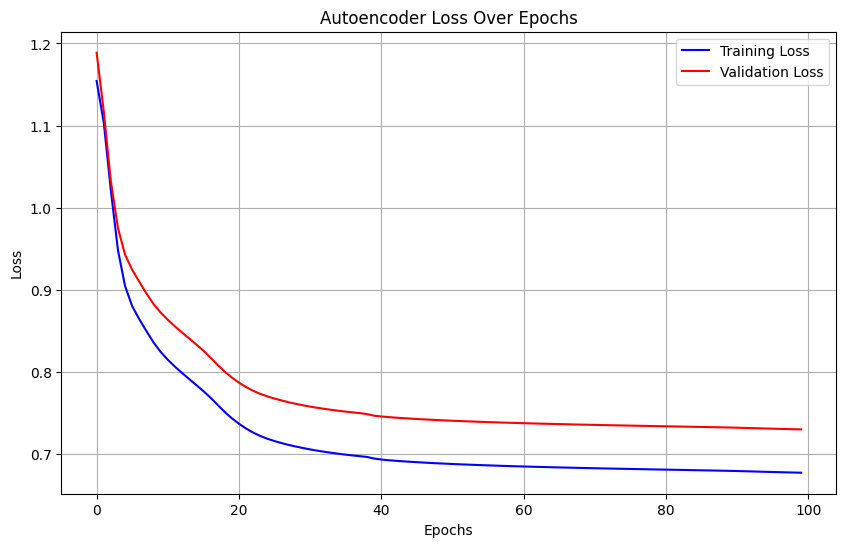

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Autoencoder Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [20]:
autoencoder.save('autoencoder_xg_model.h5')
print("Autoencoder model saved as 'autoencoder_xg_model.h5'")


Autoencoder model saved as 'autoencoder_xg_model.h5'


In [22]:
encoder_model = Model(inputs=autoencoder.input, outputs=encoded)
X_encoded = encoder_model.predict(X_scaled)

69203/69203 ━━━━━━━━━━━━━━━━━━━━ 78s 1ms/step


In [23]:
# Split encoded data for Gradient Boosting
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=42)


In [24]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_encoded, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    418201
           1       0.94      0.94      0.94    135417

    accuracy                           0.97    553618
   macro avg       0.96      0.96      0.96    553618
weighted avg       0.97      0.97      0.97    553618



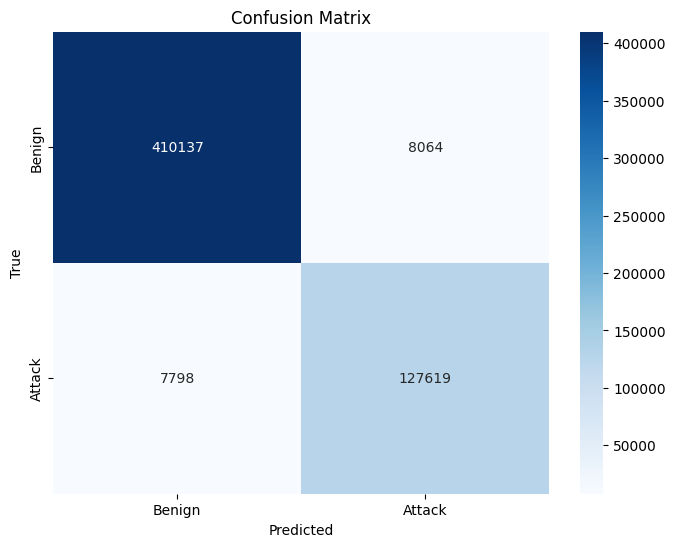

In [29]:
y_pred = xgb_model.predict(X_test_encoded)
y_pred_proba = xgb_model.predict_proba(X_test_encoded)[:, 1]

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


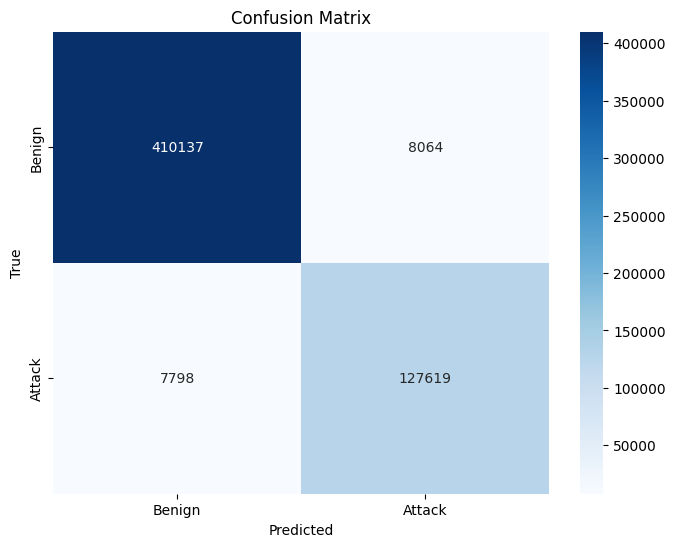

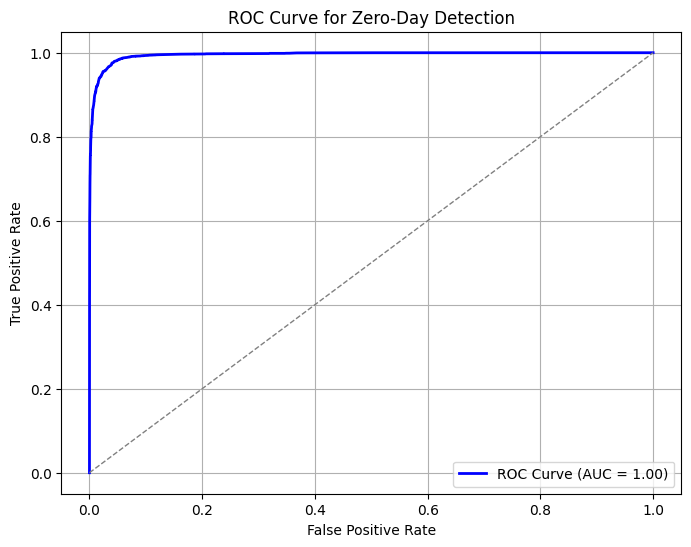

In [27]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.title('ROC Curve for Zero-Day Detection')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


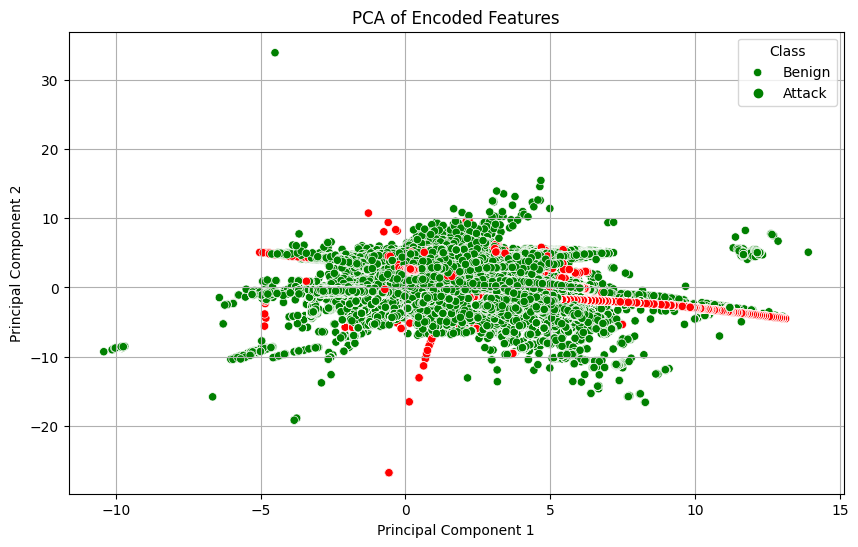

In [28]:
# PCA for Encoded Features
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_features_pca = pca.fit_transform(X_encoded)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=encoded_features_pca[:, 0], y=encoded_features_pca[:, 1],
    hue=y, palette={0: 'green', 1: 'red'}, legend='full'
)
plt.title('PCA of Encoded Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class', labels=['Benign', 'Attack'])
plt.grid()
plt.show()

In [33]:
# Calculate reconstruction errors for the entire dataset
reconstructions = autoencoder.predict(X_scaled)
reconstruction_errors = np.mean(np.square(reconstructions - X_scaled), axis=1)
data['ReconstructionError'] = reconstruction_errors


69203/69203 ━━━━━━━━━━━━━━━━━━━━ 83s 1ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


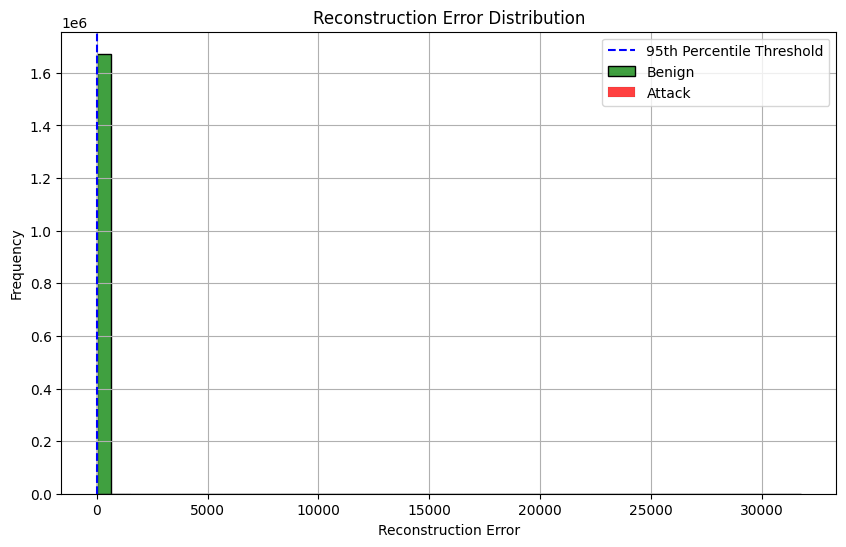

In [34]:
# Plot Reconstruction Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['ReconstructionError'][data['Label'] == 0], bins=50, color='green', label='Benign')
sns.histplot(data['ReconstructionError'][data['Label'] == 1], bins=50, color='red', label='Attack')
plt.axvline(x=np.percentile(reconstruction_errors[y == 0], 95), color='blue', linestyle='--', label='95th Percentile Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

In [43]:
print(X_test_rf.shape[1])

5



--- Classification Report (With Synthetic Data) ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    443221
           1       0.99      0.84      0.91    160397

    accuracy                           0.96    603618
   macro avg       0.97      0.92      0.94    603618
weighted avg       0.96      0.96      0.95    603618



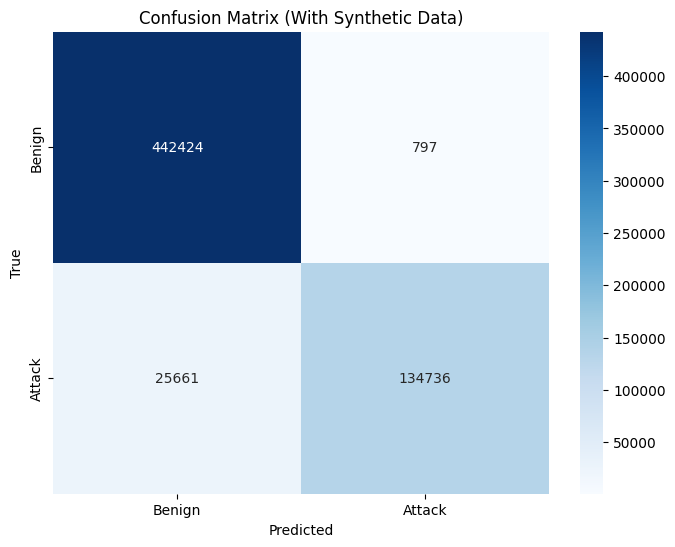

In [48]:
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate synthetic test data
synthetic_X, synthetic_y = make_classification(
    n_samples=50000,  # Number of synthetic samples
    n_features=5,  # Match the test set (553618, 5)
    n_informative=3,  # Informative features
    n_redundant=2,  # Redundant features
    n_repeated=0,  # No repeated features
    n_classes=2,  # Binary classification
    random_state=42
)

# Append synthetic data to the test set
X_test_with_synthetic = np.vstack((X_test_rf, synthetic_X))
y_test_with_synthetic = np.hstack((y_test_rf, synthetic_y))


# Evaluate the Random Forest model with synthetic data
y_pred_synthetic = rf_classifier.predict(X_test_with_synthetic)

# Classification Report with Synthetic Data
print("\n--- Classification Report (With Synthetic Data) ---")
print(classification_report(y_test_with_synthetic, y_pred_synthetic))

# Confusion Matrix
cm = confusion_matrix(y_test_with_synthetic, y_pred_synthetic)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.title('Confusion Matrix (With Synthetic Data)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Synthetic Data Class Distribution:
Benign: 25020, Attack: 24980


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


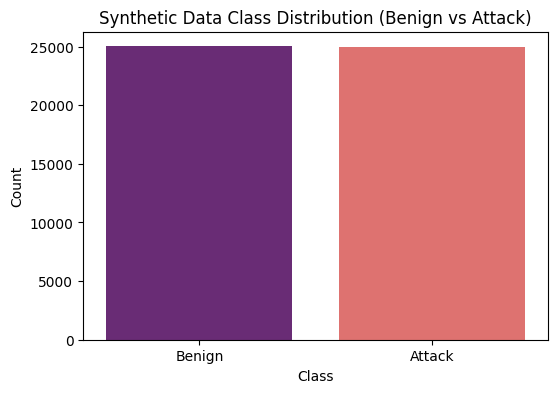

In [53]:
# Class distribution for the synthetic test data
synthetic_class_distribution = np.bincount(synthetic_y)

# Print the class distribution
print("Synthetic Data Class Distribution:")
print(f"Benign: {synthetic_class_distribution[0]}, Attack: {synthetic_class_distribution[1]}")

# Plot the class distribution for synthetic data
plt.figure(figsize=(6, 4))
sns.barplot(x=['Benign', 'Attack'], y=synthetic_class_distribution, palette='magma')
plt.title('Synthetic Data Class Distribution (Benign vs Attack)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()



--- Classification Report (With Oversampled Test Data) ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    418201
           1       1.00      0.99      1.00    418201

    accuracy                           1.00    836402
   macro avg       1.00      1.00      1.00    836402
weighted avg       1.00      1.00      1.00    836402



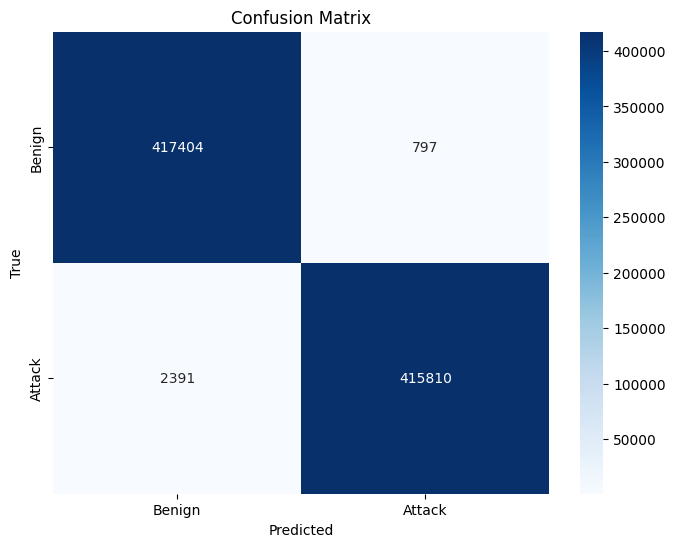

In [50]:
smote = SMOTE(random_state=42)
X_test_oversampled, y_test_oversampled = smote.fit_resample(X_test_rf, y_test_rf)

y_pred_oversampled = rf_classifier.predict(X_test_oversampled)
print("\n--- Classification Report (With Oversampled Test Data) ---")
print(classification_report(y_test_oversampled, y_pred_oversampled))

# Visualize Confusion Matrix
cm = confusion_matrix(y_test_oversampled, y_pred_oversampled)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

SMOTE Class Distribution:
Benign: 1254636, Attack: 1254636


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


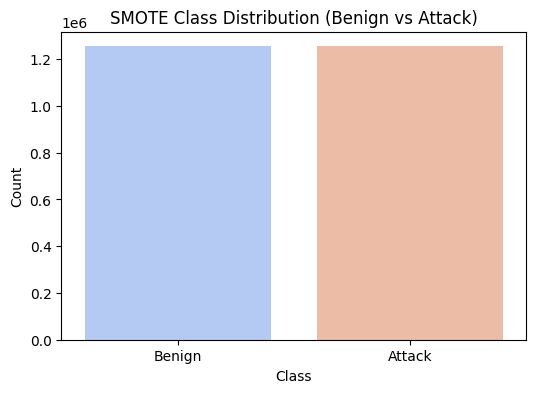

In [54]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_rf, y_train_rf)

# Class distribution after SMOTE
smote_class_distribution = np.bincount(y_train_smote)

# Print the class distribution
print("SMOTE Class Distribution:")
print(f"Benign: {smote_class_distribution[0]}, Attack: {smote_class_distribution[1]}")

# Plot the class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.barplot(x=['Benign', 'Attack'], y=smote_class_distribution, palette='coolwarm')
plt.title('SMOTE Class Distribution (Benign vs Attack)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
